# Goals of this notebook
- Build flax.linen or flax.nnx modules for the EPIC-EIC architecture.
- This involves making modules for the core with trainable weights, slots with inputs, and lookup tables (LUTs) with non-trainable inter-core connectivity $\{-1, 0, 1\}$


## Summarizing the Connectivity patterns

We have the following:
1. rows and columns
2. cores
3. i/o slots
4. neighbors to all the cores
5. per slot there are neurons. Does that mean that the neurons only exist at the slots?

## Connectivity pattern
1. Cores that share a row and/or a column are connected. Tensor $C$ specifies these cores.
   1. e.g. $C[1, 1, 1, 2]$ represents if the cores present on row 1, col 1 and row 1, col 2 are connected. They are!
2. Each core has some number of neighbors. This number depends on perhaps where the core is located -- centrally located cored will have more neighbors.
   1. The tensor $N$ contains this info. It contains a linearly intexed list (0 to num_cores-1) and number of neighbors it has.
   2. e.g. $N[3, 2] = 2$ represents that there are $3$ cores with exactly $2$ neighbors.
3. The tensor $S$ determines how the cores can talk to each other. It describes how the slots are connected
   1. $S$ specifices how a core at a given row and column is connected to one of its neighbors through which i/o slots
   2. e.g. $S[1, 2, 3, 4, 1] = 1$ would imply that the core sitting at row 1, column 2, is connected to its neighbor #4, at the input slot #3 via its output slot #1 (verify this with Johannes). The 1 represents that such a connection exists.
4. Finally $W$ is the tensor containing all the weights. To find a weight between two neuron.

## Modules needed
1. Core module: with $256 \times 256$ weights.
2. Input Slot module: can accept a signed input vector. Each core should have 4 of these
3. Output slot module: vector - matrix multiplication ($64 \times 64$ weight $64 \times 1$ input vector) -- Not sure if this needs to be imp,emented explicitly!
4. Slot LUT module: For each input module, determine which core can send inputs.
5. External input module: Module that can provide external inputs to the cores. -- Does this need to be included in the Input Slot module

## Design
1. Make a module for the core. For every core initialize $256 \times 256$ weights. Each core should receive an input vector that is $256$ elements wide. This vector is stitched together from inputs from previous layer or external inputs.
2. Make a module for slots... TBD

In [220]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import flax
from flax import linen as nn
from flax import nnx
import optax
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
from collections import defaultdict

from epic_ai_architecture_v1 import *
from binary_trident_helper_functions import *

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simplified white-matter connectivity matrix
Define $V \in \{0, 1\}^{i,j,p,q}$ matrix as the white matter mask. It indexes the following way
$V[i,j, p, q] = 1$ if there is a connection between core $C[i, j]$ and $C[p, q]$ and zero otherwise.

$$
V[i, j, p, q] = \begin{cases}
1, \quad \text{if } C[i, j] \to C[p, q] \\
0, \quad \text{otherwise}
\end{cases}
$$

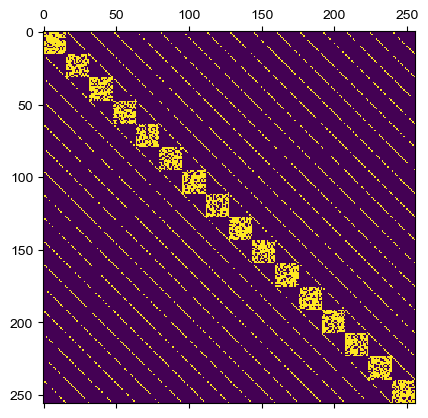

In [18]:
## simplified connectivity matrix
num_rows = 16
num_cols = 16
num_cores = num_rows * num_cols
alpha = 0.7

V = jnp.zeros((num_rows, num_cols, num_rows, num_cols))
key = jax.random.key(0)

## randomly connect all the cores on the same row, i.e. where i == p
for i in range(num_rows):
    key, split_key = jax.random.split(key)
    random_conn = jax.random.uniform(split_key, (num_cols, num_cols)) < alpha
    V = V.at[i, :, i, :].set(random_conn)

## randomly connect all the cores on the same column, i.e. where j == q
for i in range(num_cols):
    key, split_key = jax.random.split(key)
    random_conn = jax.random.uniform(split_key, (num_rows, num_rows)) < alpha
    V = V.at[:, i, :, i].set(random_conn)


# plot the matrix after reshaping
plt.matshow(V.reshape(num_cores, num_cores))


In [ ]:
# V = V.at[jnp.arange(num_rows), :, jnp.arange(num_rows), :].set(True)
# V = V.at[:, jnp.arange(num_cols), :, jnp.arange(num_cols)].set(True)

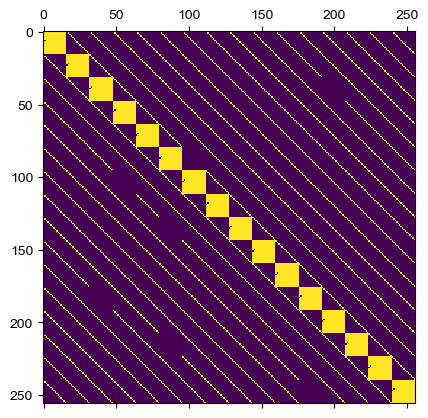

In [54]:
## is there another way to do this?
alpha = 0.99
V2 = jnp.zeros((num_rows, num_cols, num_rows, num_cols))
key, split_key = jax.random.split(key)

random_conn = jax.random.uniform(split_key, (num_cols, num_cols)) < alpha

V2 = V2.at[jnp.arange(num_rows), :, jnp.arange(num_rows), :].set(random_conn)

key, split_key = jax.random.split(key)
random_conn = jax.random.uniform(split_key, (num_rows, num_rows)) < alpha

V2 = V2.at[:, jnp.arange(num_cols), :, jnp.arange(num_cols)].set(random_conn)

plt.matshow(V2.reshape(num_cores, num_cores))

[0. 1. 0. 0. 0. 0. 0. 0. 1. 1.]


<Figure size 640x480 with 0 Axes>

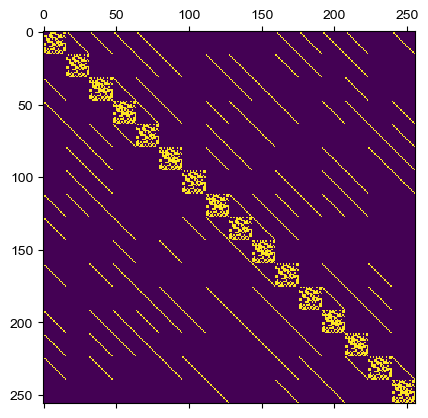

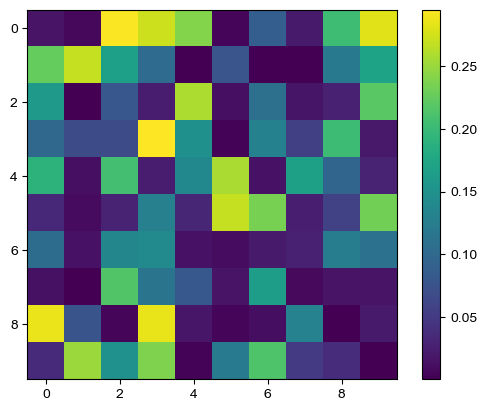

In [41]:
key = jax.random.key(0)
c1 = EICCore(num_inputs=10, num_outputs=10, key=key)
v_test = EICCore.intercore_connectivity(num_rows, num_cols, alpha, key)

x = jax.random.normal(key, (10,))*0.1
params = c1.init(key, x)
y, W = c1.apply(params, x)
print(y)

plt.figure()
plt.matshow(v_test.reshape(num_cores, num_cores))

plt.figure()
plt.imshow(W)
plt.colorbar()

In [53]:
xx = jnp.ones((5, 4))
yy = jnp.array([10, 20, 30, 40])[:, jnp.newaxis]
ww = xx @ yy
print(ww)

# x1 = x1.at[:5].set()
# x1 = x1.at[5:10] * 20
# x1 = x1.at[10:15] * 30
# x1 = x1.at[15:] * 40
# x1[:5] = x1[:5]*10
# x1[5:10] = x1[5:10]*20
# x1[10:15] = x1[10:15]*30
# x1[15:] = x1[15:]*40



[[100.]
 [100.]
 [100.]
 [100.]
 [100.]]


In [65]:
## splitting 2000 into chunks of 256
print(2000//256, 2000%256, 2000/256)

7 208 7.8125


In [68]:
1024*2/256

8.0

In [66]:
print(1000//256, 1000%256)
print(256*3 + 232)

3 232
1000


In [70]:
aa = jnp.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(aa)
print(jnp.sum(aa, axis = 0))
print(jnp.sum(aa, axis = 1))

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[12 15 18]
[ 6 15 24]


In [ ]:
def shuffle_input(x, block_size = 256, sub_block_size = 64, key = jax.random.key(0)):

    assert block_size % sub_block_size == 0, 'block_size must be a multiple of sub_block_size'

    num_sub_blocks = block_size//sub_block_size

    def shuffle_chunk(chunk, shuffle_key):
        indices = jax.random.permutation(shuffle_key, sub_block_size)
        return chunk[indices]
    
    keys = jax.random.split(key, num_sub_blocks)

    x_n = [
        shuffle_chunk(x[i * sub_block_size : (i + 1) * sub_block_size], k) 
        for i, k in zip(range(num_sub_blocks), keys)
    ]

    x_n = jnp.concatenate(x_n)

    return x, x_n

x = jnp.arange(64)
x, xn = shuffle_input(x, block_size = 16, sub_block_size = 4)

print(x[:8])
print(xn[:8])

## Correct this function!


[0 1 2 3 4 5 6 7]
[0 3 2 1 7 4 6 5]


In [ ]:
def shuffle_blocks(x, subvector_len, slot_len, key = jax.random.key(0)):
    """
    Shuffle the order of subblocks within each subvector. (Ready for deployment!)

    Args:
    x: jnp.ndarray, input vector of shape (input_len,)
    subvector_len: int, length of each subvector (typically 256 for EIC core)
    slot_len: int, length of each slot (typically 64 for EIC core)
    key: jax.random.PRNGKey, random key
    """

    assert subvector_len % slot_len == 0, "Slot length must be an integer multiple of input_len"

    ## for comments consider x = (1024,) vector

    # determine how many blocks are in the input vector
    num_subvectors = x.shape[0]//subvector_len # e.g. 1024//256 = 4 subvectors
    slots_per_input = subvector_len//slot_len # e.g. 256//64 = 4 slots per input

    # reshape x into a 3D tensor of shape (num_subvectors, slots_per_input, slot_len), e.g. (4, 4, 64)
    x_new = x.reshape(num_subvectors, slots_per_input, slot_len)

    assert x_new.shape == (num_subvectors, slots_per_input, slot_len), "Input shape is incorrect"

    # shuffle over the slots_per_input dimension
    keys = jax.random.split(key, num_subvectors) # for every subvector the key is unique

    # shuffle each subvector along index 1
    shuffled_blocks = [
        x_new[i, jax.random.permutation(keys[i], slots_per_input, independent=True)] for i in range(num_subvectors)
    ]

    # combine into a shuffled vector
    x_shuffled = jnp.concatenate([blocks.reshape(-1) for blocks in shuffled_blocks])

    return x_shuffled



Original vector (reshaped for clarity):
[[   0    1    2 ...  253  254  255]
 [ 256  257  258 ...  509  510  511]
 [ 512  513  514 ...  765  766  767]
 [ 768  769  770 ... 1021 1022 1023]]

Shuffled vector (reshaped for clarity):
[[192 193 194 ... 189 190 191]
 [448 449 450 ... 445 446 447]
 [576 577 578 ... 701 702 703]
 [960 961 962 ... 957 958 959]]


<Axes: >

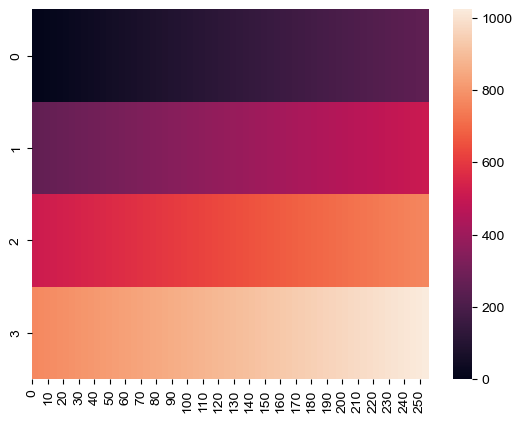

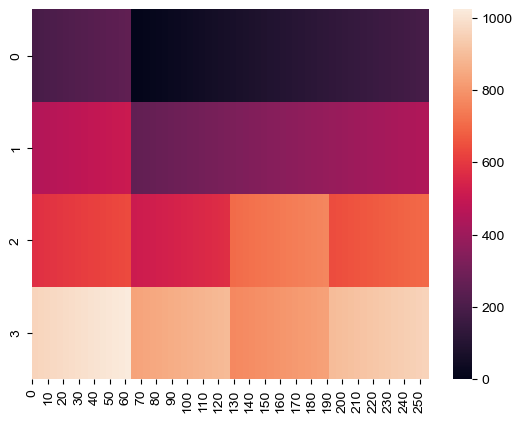

In [102]:
## testing
x = jnp.arange(1024)
key = jax.random.key(1)
subvector_len = 256
slot_len = 64

x_shuffled = shuffle_blocks(x, subvector_len, slot_len, key)

# Print results
print("Original vector (reshaped for clarity):")
print(x.reshape(-1, subvector_len))

print("\nShuffled vector (reshaped for clarity):")
print(x_shuffled.reshape(-1, subvector_len))

## visualize

plt.figure()
# plt.title("Original vector")
# plt.matshow(x.reshape(-1, subvector_len), aspect='auto')
# plt.colorbar()
sns.heatmap(x.reshape(-1, subvector_len))

plt.figure()
# plt.title("Shuffled vector")
# plt.matshow(x_shuffled.reshape(-1, subvector_len), aspect='auto')
sns.heatmap(x_shuffled.reshape(-1, subvector_len))
# plt.colorbar()

In [221]:
# toy mumtiplication problem
W = jax.random.normal(key, (2048, 1024))
W = W.reshape(8, 4, 256, 256)
print(f"Shape of cores: {W.shape}")
x = jax.random.normal(key, (1024,))
x = x.reshape(4, 256)
print(f"Shape of input: {x.shape}")
W_acc = jax.random.normal(key, (8, 256, 256))
print(f"Shape of accumulating arrays: {W_acc.shape}")

y = jnp.einsum('ijkl,jl->ijk', W, x) #multiply core-wise and accumulate over number of cores
ff = jax.nn.sigmoid
ff2 = custom_binary_gradient
y = ff2(y, threshold = 0.0, noise_sd = 0.1, key = key)
print(f"Shape of output after passing through cores: {y.shape}")

# accumulate over the row
y2 = jnp.einsum('ijk,imk->ij', W_acc, y)
y2 = ff2(y2, threshold = 0.0, noise_sd = 0.1, key = key)

# y2 = jnp.einsum('...i->i', y) # flatten
# y2 = ff2(y2, threshold = 0.0, noise_sd = 0.1, key = key)

print(f"Shape of output after accumulation: {y2.shape}")
# plt.imshow(y, aspect='auto')

print("Final output \n", y2)

Shape of cores: (8, 4, 256, 256)
Shape of input: (4, 256)
Shape of accumulating arrays: (8, 256, 256)
Shape of output after passing through cores: (8, 4, 256)
Shape of output after accumulation: (8, 256)
Final output 
 [[0. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 1. 0. 1.]
 [0. 1. 0. ... 1. 1. 1.]
 ...
 [0. 1. 0. ... 1. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 1.]]


In [140]:
## writing a skeleton function to determine legal layer sizes 
l1 = [1024, 2048, 256, 10]
l2 = [1024, 2048, 1024, 10]

def is_legal_layer(layer):
    """
    Determine if the layer size asked is valid within EIC constraints.
    Args:
     layer: list, [out_size, in_size]

    Returns:
     bool, True if the layer sizes are possible to map to EIC cores, False otherwise
    """

    out_size, in_size = layer

    num_in_blocks = out_size//256
    num_out_blocks = in_size//256

    num_cores_req = num_in_blocks * num_out_blocks
    num_cores_req += num_out_blocks # adding the phantom cores that will act as accumulators

    if num_cores_req > 64:
        raise ValueError("Layer size exceeds the number of cores in the EIC")
    else:
        return True


In [143]:
ll = [2048, 208]
print(is_legal_layer(ll))

True


## Writing down sketch of the model

### EIC-Chip module
The end structure should be of the form

```Python
forward(x):
    x = EICDense(out_size, in_size)(x) # this step applies a pseudo-feedforward map on input, the output of this step is of shape (out_size//256, in_size//256, 256)
    x = Accumulate(x) # this step accumulates the output of EICDense into the shape (out_size)
    ...
    x = Linear(10, hidden_n_size)(x)
    x = softmax(x)
```


(8, 4, 256)
[[[1. 1. 1. ... 0. 0. 0.]
  [0. 1. 1. ... 1. 1. 1.]
  [1. 1. 0. ... 1. 0. 0.]
  [1. 1. 0. ... 1. 1. 1.]]

 [[1. 1. 1. ... 0. 1. 1.]
  [0. 1. 1. ... 1. 0. 0.]
  [1. 0. 1. ... 1. 1. 1.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 1. 0. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 0.]
  [1. 0. 1. ... 0. 1. 1.]
  [1. 0. 0. ... 1. 1. 0.]]

 ...

 [[1. 1. 1. ... 0. 0. 1.]
  [1. 0. 1. ... 1. 1. 1.]
  [1. 1. 0. ... 0. 1. 0.]
  [1. 1. 0. ... 0. 1. 1.]]

 [[1. 0. 0. ... 0. 1. 0.]
  [1. 0. 0. ... 1. 1. 0.]
  [0. 0. 1. ... 0. 1. 1.]
  [1. 0. 1. ... 0. 0. 0.]]

 [[1. 1. 0. ... 1. 1. 0.]
  [0. 0. 1. ... 1. 0. 0.]
  [1. 0. 1. ... 1. 0. 1.]
  [1. 0. 1. ... 1. 0. 0.]]]
(8, 4, 256, 256)


(array([209967., 209431., 210311., 209846., 209513., 209443., 209842.,
        209876., 209257., 209666.]),
 array([0.        , 0.00191366, 0.00382733, 0.00574099, 0.00765465,
        0.00956831, 0.01148198, 0.01339564, 0.0153093 , 0.01722296,
        0.01913663]),
 <BarContainer object of 10 artists>)

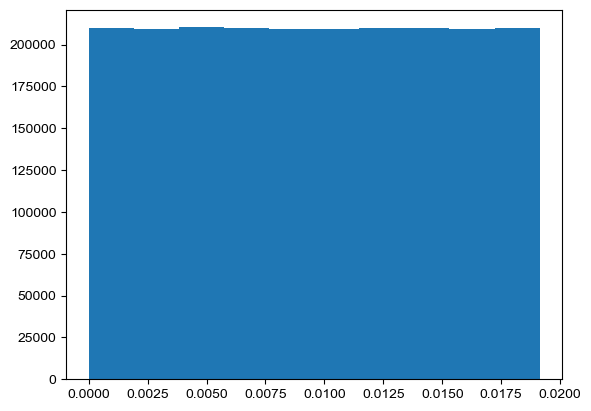

In [222]:
# defining the EICDense module
class EICDense(nn.Module):
    """
    Pseudo-dense layer using EIC Cores.
    Args:
    in_size: int, number of input neurons
    out_size: int, number of output neurons
    threshold: float, threshold for binary activation
    noise_sd: flaat, standard deviation of noise for binary activation
    key: jax.random.PRNGKey, random key

    Returns:
    x: jnp.ndarray, output of the layer
    """

    in_size: int
    out_size: int
    threshold: float
    noise_sd: float
    key: jax.random.key
    activation: callable = None

    def setup(self):
        """
        Set up dependent parameters
        """

        self.out_blocks = self.out_size//256 # number of blocks required at the output 
        self.in_blocks = self.in_size//256 # number of bloacks required at the input

        # if the number of blocks is zero, set it to 1
        if self.in_blocks == 0:
            self.in_blocks = 1
        if self.out_blocks == 0:
            self.out_blocks = 1

        self.num_cores = self.out_blocks * self.in_blocks # number of cores required
        self.W = self.param(
            "weights",
            lambda key, shape: jnp.abs(nn.initializers.xavier_uniform()(key, shape)),
            (self.out_blocks, self.in_blocks, 256, 256)
        )

        # if the activation is None, simply return linear map
        if self.activation is None:
            self.activation = self.linear_map(x, threshold = self.threshold, noise_sd = self.noise_sd, key = self.key)

    def sigmoid_fn(self, x, threshold = 0.0, noise_sd = 0.1, key = jax.random.key(0)):
        """
        Simple sigmoid.
        """
        return jax.nn.sigmoid(x)
    
    def linear_map(self, x, threshold = 0.0, noise_sd = 0.1, key = jax.random.key(0)):
        """
        Linear map
        """
        return x

    def __call__(self, x):
        """
        Forward pass of the layer
        Args:
        x: jnp.ndarray, input to the layer
        
        Returns:
        x: jnp.ndarray, output of the layer
        """

        assert x.shape == (self.in_size,), "Input shape is incorrect"

        x_reshaped = x.reshape(self.in_blocks, 256) # organize x into blocks of 256

        # make sure that the weights are positive
        W_pos= jnp.square(self.W)

        y = jnp.einsum("ijkl,jl->ijk", W_pos, x_reshaped)

        key, split_key = jax.random.split(self.key)
        y = activation(y, threshold = self.threshold, noise_sd = self.noise_sd, key = split_key)

        return y
    
# Testing the EIC module
# example parameters
key = jax.random.PRNGKey(0)
input_size = 1024
output_size = 2048
threshold = 0.0
noise_sd = 0.1
activation = custom_binary_gradient

# Input
x = jax.random.normal(key, (input_size,))

eic = EICDense(
    in_size = input_size,
    out_size = output_size,
    threshold = threshold,
    noise_sd = noise_sd,
    key = key,
    activation = activation
)

# initialize the params
params = eic.init(key, x)
y = eic.apply(params, x)
print(y.shape)
print(y)
print(params['params']['weights'].shape)
ww = params['params']['weights'].reshape(-1,)
plt.hist(ww, bins = 10)

In [168]:
10//256

0

In [223]:
# define the accumulator module
class Accumulator(nn.Module):
    """
    Accumulating the EICDense outputs. 
    Since the EICDense generates pseudo-feedforward outputs, we use a learnable accumulation matrix that minimizes error
    between the true feedforward output and the EIC output.

    Args:
        in_block_size: int, number of 256-sized blocks. This should be the .shape[0] of the EICDense output
    """

    in_block_size: int
    threshold: float
    noise_sd: float
    key: jax.random.key
    activation: callable = None

    def setup(self):
        """
        Set up the weights for the accumulator
        """

        self.W = self.param(
            "weights",
            nn.initializers.xavier_normal(),
            (self.in_block_size, 256, 256)
        )

        if self.activation is None:
            self.activation = lambda x, threshold, noise_sd, key: x

    @nn.compact
    def __call__(self, x):
        """
        Forward pass of the accumulator
        Args:
        x: jnp.ndarray, input to the accumulator
        
        Returns:
        x: jnp.ndarray, output of the accumulator
        """

        assert x.shape[0] == self.in_block_size, "Input shape is incorrect"

        y = jnp.einsum('ijk,imk->ij', self.W, x)
        y = self.activation(y, threshold = self.threshold, noise_sd = self.noise_sd, key = self.key)

        # flatten y before returning
        y = y.reshape(-1)

        return y
        
# Testing the accumulator module
acc = Accumulator(
    in_block_size = y.shape[0],
    activation = custom_binary_gradient,
    threshold = 0.0,
    noise_sd = 0.1,
    key = key
)

params_acc = acc.init(key, y)
print(params_acc['params']['weights'].shape)
y_acc = acc.apply(params_acc, y)
print(y_acc.shape)
print(y_acc)


(8, 256, 256)
(2048,)
[0. 0. 1. ... 1. 1. 0.]


(2048,)
[-1.  1.  0. ...  0. -1. -1.]


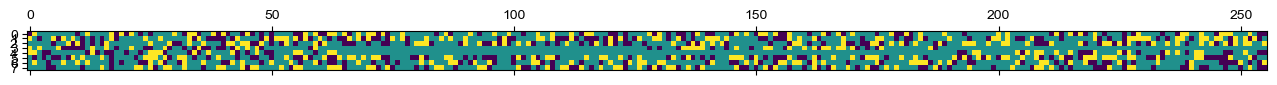

In [224]:
## define a module to split the input and shuffle it in blocks of 64
class ShuffleBlocks(nn.Module):
    """
    Shuffles an input flat vector into blocks of 64. Mathematically emulating inter-core communication.

    Args:
        subvector_len: int, length of each subvector (typically 256 for EIC core)
        slot_len: int, length of each slot (typically 64 for EIC core)
        key: jax.random.PRNGKey, random key

    Returns:
        (xp - xn): jnp.ndarray, shuffled input vector of shape (input_len,)
    """
    subvector_len: int
    slot_len: int
    key: jax.random.key

    @nn.compact
    def __call__(self, x):
        """
        Shuffle input vector x block-wise 
        Args:
        x: jnp.ndarray, input vector of shape (input_len,)

        Returns:
        x_shuffled: jnp.ndarray, shuffled input vector of shape (input_len,)
        """
        assert self.subvector_len % self.slot_len == 0, "Slot length must be an integer multiple of input_len"

        ## for comments consider x = (1024,) vector

        # determine how many blocks are in the input vector
        num_subvectors = x.shape[0]//self.subvector_len # e.g. 1024//256 = 4 subvectors
        slots_per_input = self.subvector_len//self.slot_len # e.g. 256//64 = 4 slots per input

        # reshape x into a 3D tensor of shape (num_subvectors, slots_per_input, slot_len), e.g. (4, 4, 64)
        x_reshaped = x.reshape(num_subvectors, slots_per_input, self.slot_len)

        # shuffle over slots_per_input dimension

        ## for positive vector
        key, subkey = jax.random.split(self.key)
        keys = jax.random.split(key, num_subvectors)

        shuffled_blocks_pos = [
            x_reshaped[i, jax.random.permutation(keys[i], slots_per_input, independent=True)] for i in range(num_subvectors)
        ]

        xpos = jnp.concatenate([blocks.reshape(-1) for blocks in shuffled_blocks_pos])

        # for negative vector
        key, subkey = jax.random.split(subkey)
        keys = jax.random.split(key, num_subvectors)

        shuffled_blocks_neg = [
            x_reshaped[i, jax.random.permutation(keys[i], slots_per_input, independent=True)] for i in range(num_subvectors)
        ]

        xneg = jnp.concatenate([blocks.reshape(-1) for blocks in shuffled_blocks_neg])

        return xpos - xneg

## testing shuffle module
sh = ShuffleBlocks(
    subvector_len = 256,
    slot_len = 64,
    key = key
)

params_sh = sh.init(key, x)
y_acc_sh = sh.apply(params_sh, y_acc)
print(y_acc_sh.shape)
print(y_acc_sh)
plt.matshow(y_acc_sh.reshape(-1, 256))

(256,)


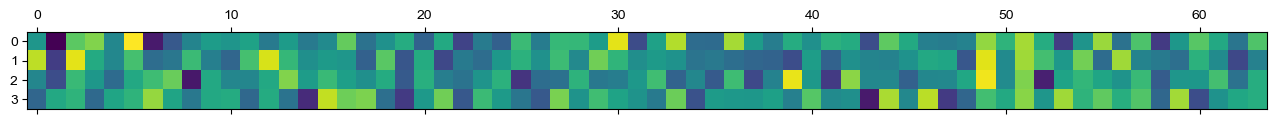

In [ ]:
class PseudoFFNet(nn.Module):

    @nn.compact
    def __call__(self, x):
        #1024 -> 2048
        sh1 = ShuffleBlocks(
            subvector_len = 256,
            slot_len = 64,
            key = key
        )

        sh1_params = sh1.init(key, x)
        x_shuffled = sh1.apply(sh1_params, x)

        fc1 = EICDense(
            in_size = 1024,
            out_size = 2048,
            threshold = 0.0,
            noise_sd = 0.1,
            key = key,
            activation = custom_binary_gradient
        )

        fc1_params = fc1.init(key, x_shuffled)
        y = fc1.apply(fc1_params, x_shuffled)

        ac1 = Accumulator(
            in_block_size = y.shape[0],
            threshold = 0.0,
            noise_sd = 0.1,
            key = key,
            activation = custom_binary_gradient #lambda x, threshold, noise_sd, key: x
        )

        ac1_params = ac1.init(key, y)
        y = ac1.apply(ac1_params, y)

        # 2048 -> 256
        sh2 = ShuffleBlocks(
            subvector_len = 256,
            slot_len = 64,
            key = key
        )

        sh2_params = sh2.init(key, y)
        y = sh2.apply(sh2_params, y)

        fc2 = EICDense(
            in_size = 2048,
            out_size = 256,
            threshold = 0.0,
            noise_sd = 0.1,
            key = key,
            activation = custom_binary_gradient
        )

        fc2_params = fc2.init(key, y)
        y = fc2.apply(fc2_params, y)

        ac2 = Accumulator(
            in_block_size = y.shape[0],
            threshold = 0.0,
            noise_sd = 0.1,
            key = key,
            activation = custom_binary_gradient
        )

        ac2_params = ac2.init(key, y)
        y = ac2.apply(ac2_params, y)

        # 256 -> 10 (256)
        sh3 = ShuffleBlocks(
            subvector_len = 256,
            slot_len = 64,
            key = key
        )
        sh3_params = sh3.init(key, y)
        y = sh3.apply(sh3_params, y)

        fc3 = EICDense(
            in_size = 256,
            out_size = 10,
            threshold = 0.0,
            noise_sd = 0.1,
            key = key,
            activation = custom_binary_gradient
        )
        fc3_params = fc3.init(key, y)
        y = fc3.apply(fc3_params, y)

        ac3 = Accumulator(
            in_block_size = y.shape[0],
            threshold = 0.0,
            noise_sd = 0.1,
            key = key,
            activation = lambda x, threshold, noise_sd, key: x # linear map
        )

        ac3_params = ac3.init(key, y)
        y = ac3.apply(ac3_params, y)

        return y

key = jax.random.key(0)
x = jax.random.normal(key, (1024,))
# y = toy_pipeline(x, key)
# print(y.shape)
# plt.matshow(y.reshape(-1, 256))
net1 = PseudoFFNet()
rng = jax.random.PRNGKey(0)
params = net1.init(rng, x)
y = net1.apply(params, x)   
print(y.shape)
plt.matshow(y.reshape(-1, 64))

In [234]:
print(y[:10])

[-0.00418948 -1.8003218   0.7461114   0.96143365 -0.22128552  1.6091324
 -1.5489776  -0.84767604 -0.26208776  0.08853047]


In [ ]:
## testing the load mnist function
DATA_PATH = f"/Users/vikrantjaltare/OneDrive - UC San Diego/Datasets/"

def load_and_process_mnist(data_path, binarize):
    """
    Pipeline to load, binarize, resize and batch MNIST dataset.
    Args:
        data_path: str, path to the data
        batch_size: int, batch size
        binarize: bool, whether to binarize the data or not
    Returns:
        (train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels): tuple, tuple, tuple of jnp.ndarray
    """

    # load the dataset
    ds_train, ds_test = tfds.load(
        'mnist',
        split = ['train', 'test'],
        shuffle_files = True,
        as_supervised = True,
        data_dir = data_path
    )

    # normalize and convert to numpy
    def normalize_image(image, label):
        image = tf.cast(image, tf.float32)/ 255.0

        if binarize:
            image = tf.where(image < 0.5, 0.0, 1.0)

        return image, label
    
    train_data = ds_train.map(normalize_image)
    test_data = ds_test.map(normalize_image)

    # separate images and samples
    train_images, train_labels = zip(*train_data)
    test_images, test_labels = zip(*test_data)

    # convert tuples to numpy arrays
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)

    # pad the images with zeros to get 32x32 images
    train_images = jnp.pad(train_images, pad_width = ((0, 0), (2, 2), (2, 2), (0, 0)), mode = 'constant', constant_values = 0)
    test_images = jnp.pad(test_images, pad_width = ((0, 0), (2, 2), (2, 2), (0, 0)), mode = 'constant', constant_values = 0)

    # concatenate to create a single dataset
    images = np.concatenate([train_images, test_images], axis = 0)
    labels = np.concatenate([train_labels, test_labels], axis = 0)

    # split the data 50k-10k-10k
    train_images, val_images, test_images = images[:50000], images[50000:60000], images[60000:]
    train_labels, val_labels, test_labels = labels[:50000], labels[50000:60000], labels[60000:]

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

def get_train_batches(train_images, train_labels, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    ds = ds.shuffle(len(train_images)).batch(batch_size).prefetch(1)
    return tfds.as_numpy(ds)

Train images shape: (60000, 32, 32, 1), Test images shape: (10000, 32, 32, 1)


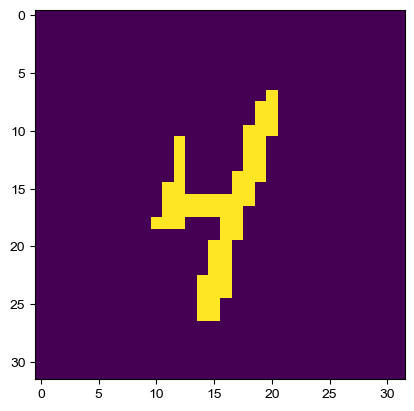

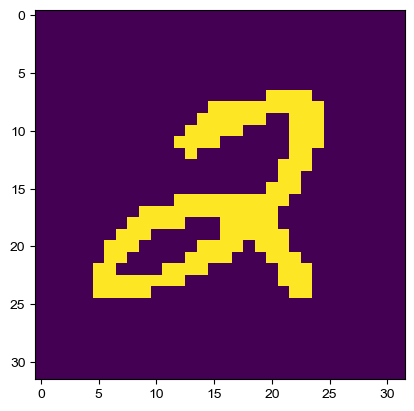

In [218]:
i1, i2 = load_and_process_mnist(DATA_PATH, True)
plt.figure()
plt.imshow(i1)

plt.figure()
plt.imshow(i2)

(5, 32, 32, 1)


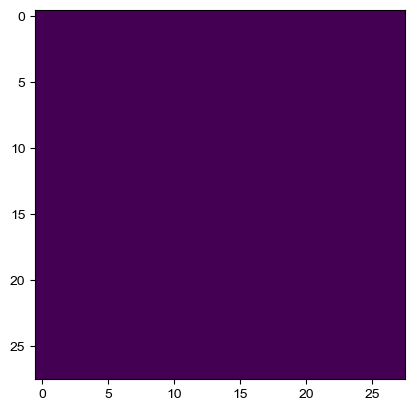

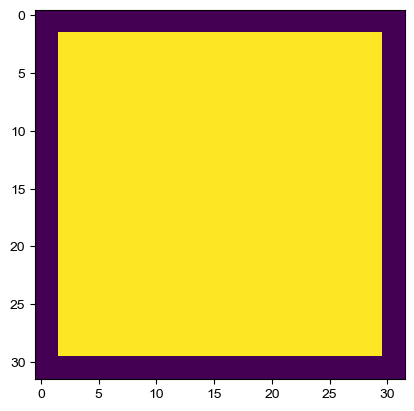

In [216]:
a1 = jnp.ones((5, 28, 28, 1))
a2 = jnp.pad(a1, pad_width = ((0,0), (2, 2), (2, 2), (0, 0)), mode = "constant")
print(a2.shape)

plt.figure()
plt.imshow(a1[0])

plt.figure()
plt.imshow(a2[0])

In [245]:
print(y[:10])

[-0.00418948 -1.8003218   0.7461114   0.96143365 -0.22128552  1.6091324
 -1.5489776  -0.84767604 -0.26208776  0.08853047]


In [250]:
def accuracy(params, model, input, targets):
    """
    Compute accuracy of the model.
    Args:
    params: flax model parameters
    model: flax model
    input: jnp.ndarray, input data
    targets: jnp.ndarray, target data
    """

    logits = model.apply(params, input)

    # truncate the logits to first 10 elements
    if len(logits) > 10:
        logits = logits[:10]

    predicted_labels = jnp.argmax(logits, axis = -1)
    acc = jnp.mean(predicted_labels == targets)

    return acc

def cross_entropy_loss(logits, targets):
    """
    Compute cross entropy loss.
    Args:
    logits: jnp.ndarray, predicted labels
    targets: jnp.ndarray, targets
    """
    # truncate the logits to first 10 elements
    if len(logits) > 10:
        logits = logits[:10]

    one_hot_labels = jax.nn.one_hot(targets, num_classes = 10)

    assert len(logits) == len(one_hot_labels), "Length of logits and targets should be same"

    probits = jax.nn.log_softmax(logits)

    ce_loss = -jnp.mean(jnp.sum(one_hot_labels * probits, axis = -1))

    return ce_loss

In [251]:
celoss = cross_entropy_loss(y, 6)
print(celoss)

4.201384


In [254]:
acc = accuracy(params, net1, x, 5)
print(acc)

1.0


## Training pipeline